In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer #fills in missing values in dataset with most frequent column
from sklearn.preprocessing import LabelEncoder, StandardScaler #encodes categorical data and scaling numerical data
from sklearn.model_selection import train_test_split #splits into training and testing 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc # evaluate models 
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # for matrix


In [2]:
# load dataset
final_dataset = pd.read_csv("final_dataset.csv")

# if i set low_memory = False....runtime error happens and it crashes

/var/folders/bz/ktwf_w750h57p937342y7bsr0000gn/T/ipykernel_17919/1740902573.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  final_dataset = pd.read_csv("final_dataset.csv")


In [3]:
# fill in missing values with most frequent stuff, using SimpleImputer..imputer
imputer = SimpleImputer(strategy = 'most_frequent')  # most frequent would be not fraud
# cc_num doesnt correlate as much and has missing data
final_dataset['cc_num'] = imputer.fit_transform(final_dataset[['cc_num']])
# same thing with the time...some were empty
final_dataset['unix_time'] = imputer.fit_transform(final_dataset[['unix_time']])
# fit() looks for the most frequent value and transform() replaces empty values with them

In [4]:
# encode categorical variables
cat_cols = ['merchant', 'category', 'city', 'state'] #category columns
label_enc = {} # stores label encoders for the columns
# for loop to go through each category
for col in cat_cols:
    le = LabelEncoder()
    final_dataset[col] = le.fit_transform(final_dataset[col]) # convert to numbers
    label_enc[col] = le
# so ['H', 'i'] will be [0, 1]
# merchant, city, and state are converted to integers
# category is encoded

In [5]:
# keep only rows that are 0 or 1.......had to b/c some were string inputs or invalid
final_dataset = final_dataset[final_dataset['is_fraud'].isin(['0', '1'])]
final_dataset['is_fraud'] = final_dataset['is_fraud'].astype(int)

In [6]:
# count how many values there are (0 and 1) 
print(final_dataset['is_fraud'].value_counts())

is_fraud
0    63426
1     2108
Name: count, dtype: int64


In [7]:
# scale data and replace with smaller numbers for models
scale = StandardScaler()
numerical_cols = ['amt', 'lat', 'long', 'merch_lat', 'merch_long']
# scales data for easier numbers with fit.tranform() 
final_dataset[numerical_cols] = scale.fit_transform(final_dataset[numerical_cols])
# gets mean and standard deviation from data
# StandardScaler subtracts the mean from each column and divides by the standard deviation 
# mean will become 0 and variance becomes 1

In [8]:
# split the dataset into train and test sets
# import train_test_split
X = final_dataset.drop(columns = ['is_fraud', 'trans_date_trans_time', 'trans_num']) # features dropped..date/time b/c of input format..trans_num b/c of unique identifiers
# is_fraud is target variable
y = final_dataset['is_fraud'] # holds the transactions that are 0 or 1...fraud or nonfraud
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 50, stratify = y)
# train_test_split trains at 70% and tests 30%

# X are the features, y is is_fraud
# random_state makes sure the same random subseta are used....i put 50 
# stratify = y makes sure the split has the same number of classes...fraud/nonfraud....avoids imbalance data...part of train_test_split

In [9]:
# print sizes of data 
print(f"Training set size- {X_train.shape[0]} rows")
print(f"Testing set size- {X_test.shape[0]} rows")

Training set size- 45873 rows
Testing set size- 19661 rows


In [10]:
# random forest

rf_model = RandomForestClassifier(n_estimators = 50, random_state = 50, n_jobs =- 1)
# n_estimators is the number of trees in rf_model
# random _state makes sure the same random subsets are used
# n_jobs is how many CPU cores my laptop uses for training
rf_model.fit(X_train, y_train) # features, target 

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=50)

In [11]:
# gradient boosting
gb_model = GradientBoostingClassifier(n_estimators = 50, random_state = 50)
gb_model.fit(X_train, y_train) # features, target
# n_estimators is the number of models in rf_model
# random _state makes sure the same random subsets are used

GradientBoostingClassifier(n_estimators=50, random_state=50)


Model: Random Forest
Accuracy-  0.9907430954681857
ROC/AUC-  0.9855264216974625
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19029
           1       0.94      0.76      0.84       632

    accuracy                           0.99     19661
   macro avg       0.96      0.88      0.92     19661
weighted avg       0.99      0.99      0.99     19661

Precision-Recall AUC for Random Forest: 0.89


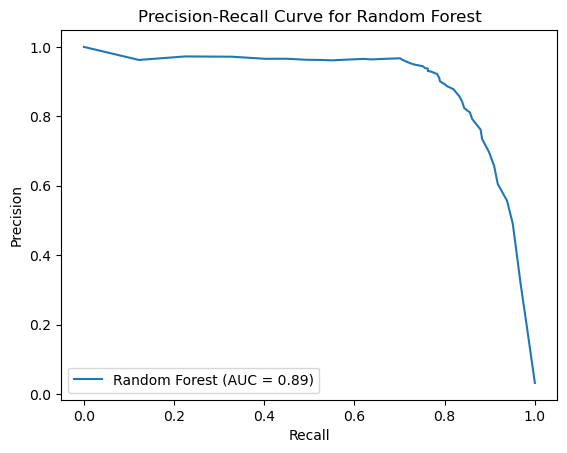

Confusion Matrix for Random Forest:
[[18997    32]
 [  150   482]]


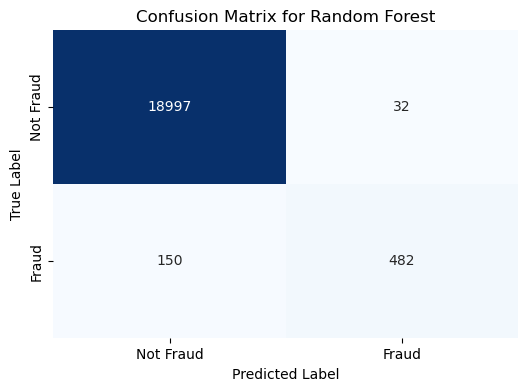


Model: Gradient Boosting
Accuracy-  0.9874879202482071
ROC/AUC-  0.9797653947239757
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19029
           1       0.91      0.68      0.78       632

    accuracy                           0.99     19661
   macro avg       0.95      0.84      0.88     19661
weighted avg       0.99      0.99      0.99     19661

Precision-Recall AUC for Gradient Boosting: 0.85


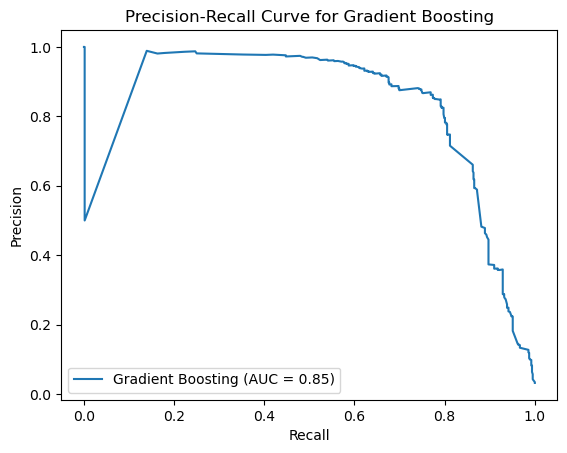

Confusion Matrix for Gradient Boosting:
[[18988    41]
 [  205   427]]


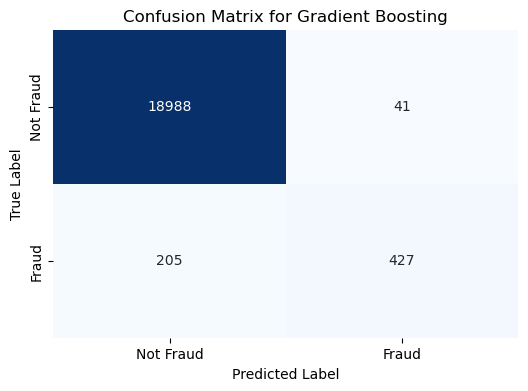

In [12]:
# evaluate models
# put them all together to make it easier
models = {'Random Forest': rf_model, 'Gradient Boosting': gb_model}

# for loop for each model
for model_name, model in models.items():
    y_pred = model.predict(X_test) # predicts for test set (0 or 1)
    y_pred_prob = model.predict_proba(X_test)[:, 1] #predicts prob. of fraud trans in test set
    # [:,1] chooses fraud trans
    print(f"\nModel: {model_name}")
    print("Accuracy- ", accuracy_score(y_test, y_pred)) # sklearn-metrics import
    print("ROC/AUC- ", roc_auc_score(y_test, y_pred_prob)) # sklearn-metrics import
    print(classification_report(y_test, y_pred)) # sklearn-metrics import
    # precision- checks how many predicted frauds are actually fraud
    # recall- gets the number of correctly identified fraud trans 
    # F1 score- mean of precision and recall
    # support- number of samples for each class, fraud/nonfraud
    
    # precision recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    # aoc for pr curve
    pr_auc = average_precision_score(y_test, y_pred_prob)
    print(f"Precision-Recall AUC for {model_name}: {pr_auc:.2f}")
    # average_precision_score summarizes curve into a value...
    
    # graph stuff
    plt.figure()
    plt.plot(recall, precision, label = f'{model_name} (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc = 'lower left')
    plt.show()
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {model_name}:")
    print(cm)
    # [ a b ] a = true negatives    b = false positives
    # [ c d ] c = false negatives   d = true positives

    # grpah matrix
    plt.figure(figsize = (6, 4))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False, 
                xticklabels = ["Not Fraud", "Fraud"], 
                yticklabels = ["Not Fraud", "Fraud"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
    
    # ROC curve (receiver operating characteristic curve)
    fp, tp, _ = roc_curve(y_test, y_pred_prob) # fp- false positive, tp- true positive (recall)
    # _ ignores the third value in roc_curve...used to calculate thresholds
    roc_auc = auc(fp, tp) # calculate area under curve for ROC


In [28]:
# compare models and finds best one based on values
# X_test - features for predicting
# y_test - correct prediction
def compare(models, X_test, y_test):
    results = {} # stores results
    for model_name, model in models.items(): 
        # stores predcition values 
        y_pred = model.predict(X_test) # predicts for test set (0 or 1)
        y_pred_prob = model.predict_proba(X_test)[:, 1] # prob. of fraud trans in test set
        # [:,1] gets the correct is_fraud values : = all, 1 = is_fraud

        # calculating values for comparison
        # y_test - correct prediction
        # y_pred - fraud/nonfraud
        # y_pred_prob - fraud trans in test set
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
        pr_auc = average_precision_score(y_test, y_pred_prob)

        # store values
        results[model_name] = {
            "Accuracy": accuracy,
            "ROC-AUC": roc_auc,
            "PR-AUC": pr_auc,
            "Precision": precision,
            "Recall": recall
        }

        # print results
        print(f"\nModel- {model_name}")
        print(f"Accuracy- {accuracy:.4f}")
        print(f"ROC/AUC- {roc_auc:.4f}")
        print(f"PR/AUC- {pr_auc:.4f}")

    # compare models
    # finds model with highest roc-auc 
    # max() finds max value in iterations
    # it looks at each item and extracts roc/auc value with lambda 
    best_model = max(results.items(), key = lambda x: x[1]["ROC-AUC"])[0]
    # stores that ^ value
    best_roc_auc = results[best_model]["ROC-AUC"]

    # print final results
    print("\nModel Comparison Results")
    for model_name, metrics in results.items():
        print(f"\nModel- {model_name}")
        print(f"- Accuracy- {metrics['Accuracy']:.4f}")
        print(f"- ROC/AUC- {metrics['ROC-AUC']:.4f}")
        print(f"- PR/AUC- {metrics['PR-AUC']:.4f}")

        # checks if model is actually best
        if model_name == best_model:
            print(f"\nBest Model- {model_name}")
            print(f"It has the highest ROC/AUC score ({best_roc_auc:.4f})")
            print(f"It has the highest PR/AUC score ({metrics['PR-AUC']:.4f})")
        else:
            print(f"Has lower ROC/AUC ({metrics['ROC-AUC']:.4f}) compared to {best_model}")
    return best_model, results

# models
models = {
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model
}

# compare
best_model, model_results = compare(models, X_test, y_test) # features, correct prediction

# print final result
print(f"\nBest Model Overall------ {best_model}")



Model- Random Forest
Accuracy- 0.9907
ROC/AUC- 0.9855
PR/AUC- 0.8886

Model- Gradient Boosting
Accuracy- 0.9875
ROC/AUC- 0.9798
PR/AUC- 0.8482

Model Comparison Results

Model- Random Forest
- Accuracy- 0.9907
- ROC/AUC- 0.9855
- PR/AUC- 0.8886

Best Model- Random Forest
It has the highest ROC/AUC score (0.9855)
It has the highest PR/AUC score (0.8886)

Model- Gradient Boosting
- Accuracy- 0.9875
- ROC/AUC- 0.9798
- PR/AUC- 0.8482
Has lower ROC/AUC (0.9798) compared to Random Forest

Best Model Overall------ Random Forest
